In [1]:
import rebound as rb
import numpy as np
from celmech import Poincare,PoincareHamiltonian
from sympy import init_printing
import matplotlib.pyplot as plt
import pickle

init_printing()

In [9]:
from sympy import symbols

from sympy import S,diff

In [2]:
with open("./Kepler_60_MCMC_median_param_values.pkl","rb") as fi:
    medians = pickle.load(fi)

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f843710>)

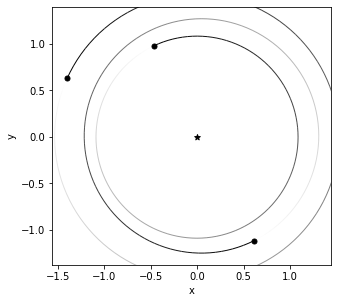

In [3]:
np.random.seed(1)
sim = rb.Simulation()
sim.add(m=1)
for i in range(3):
    sim.add(
        m = medians['mu{}'.format(i)],
        P = medians['per{}'.format(i)],
        e = medians['e{}'.format(i)],
        l = medians['mean_long{}'.format(i)],
        pomega = medians['pomega{}'.format(i)],
        Omega = np.random.uniform(0,2*np.pi),
        inc = np.random.rayleigh(0.01)
    )

rb.OrbitPlot(sim)

In [4]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

In [5]:
sim.particles[2].P/sim.particles[1].P,sim.particles[3].P/sim.particles[2].P

In [6]:
pham.add_all_MMR_and_secular_terms(5,1,max_order=2,indexIn=1,indexOut=2)
pham.add_all_MMR_and_secular_terms(4,1,max_order=2,indexIn=2,indexOut=3)

pham.add_all_secular_terms(2,indexIn=1,indexOut=3)

# Hamiltonian
Print the symbolic Hamiltonian of the system

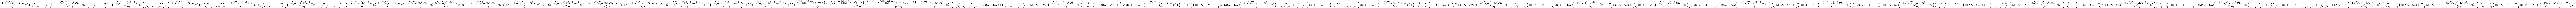

In [17]:
pham.H

# Matrix entries of the canonical equations

$$
\frac{d}{dt}\begin{pmatrix}\eta_1 \\ \kappa_1 \\ ... \\ \rho_1 \\ \sigma_1 \\... \end{pmatrix}
= \begin{pmatrix}\frac{\partial H}{\partial \kappa_1}\\ -\frac{\partial H}{\partial \eta_1} \\ ... \\ \frac{\partial H}{\partial \sigma_1}\\ -\frac{\partial H}{\partial \rho_1}  \\... \end{pmatrix} = \Omega \cdot\left(\nabla H({e=0,I=0}) +  \Omega\cdot\nabla^2H \cdot \begin{pmatrix}\eta_1 \\ \kappa_1 \\ ... \\ \rho_1 \\ \sigma_1 \\... \end{pmatrix} + ...\right)
$$ 

As an example, lets get a few terms of $d\eta_1/dt$

In [18]:
from sympy import substitution

In [20]:
eta1dot = pham.derivs[S('eta1')]

In [34]:
ecc_and_inc_indices=[]
for i in range(pham.N-1):
    ecc_and_inc_indices += [6*i,6*i+1,6*i+4, 6*i+5]

In [39]:
set_ecc_and_inc_zero_dict = {pham.varsymbols[i]:0. for i in ecc_and_inc_indices}

## constant term on r.h.s.

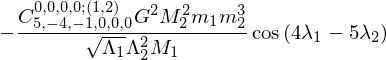

In [40]:
eta1dot.subs(set_ecc_and_inc_zero_dict)

## diagonal element of $\nabla^2H$

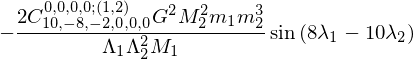

In [41]:
diff(pham.derivs[S('eta1')],S('eta1'))

## some other term...

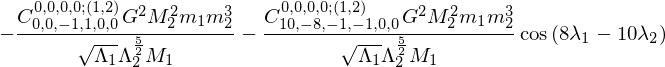

In [43]:
diff(pham.derivs[S('eta1')],S('kappa2'))